In [1]:
#Загружаем наш дата сет. Мы имеем дата сет из 10 колонок (Age, Sex, ALP, ALT, AST, BIL, CHE, CHOL, CREA, Category) и 615 строк. Есть как числовые, так и качественные переменные. Крайний столбец Category выступает как классификатор.

In [1]:
# Загружаем необходимые библиотеки для начала работы (Numpy, Matplotlib.pyplot ,Pandas)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Загружаем дата сет в формате сsv, разделитель запятые.
df = pd.read_csv('cont.csv', sep=',' )

In [3]:
# Проверяем как загрузился дата сет. Сразу видно присутствие NaN в столбцах
df

,Age,Sex,ALP,ALT,AST,BIL,CHE,CHOL,CREA,Category
0,32,m,52.5,7.7,22.1,7.5,6.93,3.23,106.0,0
1,32,m,70.3,18.0,24.7,3.9,11.17,4.80,74.0,0
2,32,m,74.7,36.2,52.6,6.1,8.84,5.20,86.0,0
3,32,m,52.0,30.6,22.6,18.9,7.33,4.74,80.0,0
4,32,m,74.1,32.6,24.8,9.6,9.15,4.32,76.0,0
...,...,...,...,...,...,...,...,...,...,...
610,62,f,416.6,5.9,110.3,50.0,5.57,6.30,55.7,1
611,64,f,102.8,2.9,44.4,20.0,1.54,3.02,63.0,1
612,64,f,87.3,3.5,99.0,48.0,1.66,3.63,66.7,1
613,46,f,NaN,39.0,62.0,20.0,3.56,4.20,52.0,1


In [4]:
# Проверяем и заменяем пропуски в числовых столбцах дата сета.
def fill_missing_num(x):
    num_var = list(x._get_numeric_data().columns)
    for col_names in num_var:        
        prep_med = SimpleImputer(missing_values=np.nan, strategy='mean')
        prep_med.fit(x[num_var])
        x[num_var] = prep_med.transform(x[num_var])
    return(x)

In [5]:
# Заполняем значения NaN с помощью SimpleImputer.
from sklearn.impute import SimpleImputer
df = fill_missing_num(df)

In [7]:
# Производим кодирование всех качественных переменных, в нашем случае только столбец Sex.
def encoding_char(x):
    char_var = list(set(x.columns) - set(x._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(x[col_names])
        x[col_names] = pd.factorize(x[col_names])[0]
    return(x)

In [8]:
df = encoding_char(df)

In [9]:
# Делим наш дата сет на обучающую и тестирующую выборку в пропорции 20/80.
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [10]:
# Производим шкалирование наших данных без нашей эдогенной переменной Category.
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler().fit(X_train)
X_train = sc_X.transform(X_train)
X_test = sc_X.transform(X_test)

In [11]:
# Строим базовую модель и смотрим на полученный отчет. Можно сделать вывод, что значимых перменных только две, это х4 (ALT) и х5 (AST). Будем использовать их для построения наших классификаторов.
import statsmodels.api as sm
lr = sm.Logit(y_train, X_train).fit()
print(lr.summary2())

Optimization terminated successfully.
         Current function value: 0.312738
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.214     
Dependent Variable: y                AIC:              325.7338  
Date:               2020-11-23 12:00 BIC:              363.5201  
No. Observations:   492              Log-Likelihood:   -153.87   
Df Model:           8                LL-Null:          -195.80   
Df Residuals:       483              LLR p-value:      8.1273e-15
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
--------------------------------------------------------------------
       Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
--------------------------------------------------------------------
x1     0.0023      0.1505     0.0155    0.9877    -0.2927     0.2973
x2     0.1901      0.1652     1.1504    0.2500    -0.1

In [13]:
# Остлавляем только значимые переменные.
X_train = X_train[:,[3,4]]
X_test = X_test[:,[3,4]]

In [14]:
# Обучаем модель логистической регрессии.
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 13).fit(X_train, y_train)

In [15]:
# Делаем прогноз на тестовой выборке. Уровень качества модели очень высок, превышает 95%, то  есть 95% объектов распознано верно.
y_pred = lr.predict(X_test)
lr.score(X_test,y_test)

0.959349593495935

In [16]:
# Строим таблицу сопряженности. Можно сделать вывод, что 5 положительных случая ложно определены как отрицательные. 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[108   0]
 [  5  10]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


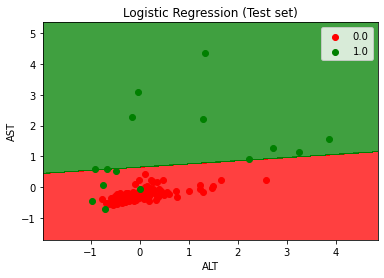

In [17]:
# Строим область значений. Они отделяются линейно. Зелёные точки - больные люди, красные точки - здоровые. Люди с повышенным значением AST более склонны к болезни. 
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, lr.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression (Test set)')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.legend()
plt.show()

In [18]:
# Устанавливаем необходимые пакеты Keras.
import keras
from keras.models import Sequential
from keras.layers import Dense

In [52]:
# Строим нейронную сеть прямой передачи сигнала. На входном слое 8 нейрона (усложнее). Используем функцию relu, которая позволит учесть наличие линейнносоти в исходных данных. На втором слое выбирем 1 нейрон используя сигмоидальную функцию. 
cnn = Sequential()
cnn.add(Dense(units = 8,  activation = 'relu', input_dim = 2))
cnn.add(Dense(units = 1,  activation = 'sigmoid'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [53]:
# Обучаем нейронную сеть в течении 100 эпох.
cnn.fit(X_train, y_train, epochs = 100, batch_size = 8)

Epoch 1/100
62/62 [==============================] - 0s 502us/step - loss: 0.7031 - accuracy: 0.3476
Epoch 2/100
62/62 [==============================] - 0s 466us/step - loss: 0.6257 - accuracy: 0.8923
Epoch 3/100
62/62 [==============================] - 0s 482us/step - loss: 0.5684 - accuracy: 0.9126
Epoch 4/100
62/62 [==============================] - 0s 466us/step - loss: 0.5181 - accuracy: 0.9289
Epoch 5/100
62/62 [==============================] - 0s 483us/step - loss: 0.4728 - accuracy: 0.9309
Epoch 6/100
62/62 [==============================] - 0s 450us/step - loss: 0.4307 - accuracy: 0.9370
Epoch 7/100
62/62 [==============================] - 0s 434us/step - loss: 0.3925 - accuracy: 0.9370
Epoch 8/100
62/62 [==============================] - 0s 448us/step - loss: 0.3586 - accuracy: 0.9390
Epoch 9/100
62/62 [==============================] - 0s 450us/step - loss: 0.3293 - accuracy: 0.9390
Epoch 10/100
62/62 [==============================] - 0s 499us/step - loss: 0.3042 - accura

62/62 [==============================] - 0s 434us/step - loss: 0.1368 - accuracy: 0.9492
Epoch 82/100
62/62 [==============================] - 0s 450us/step - loss: 0.1366 - accuracy: 0.9472
Epoch 83/100
62/62 [==============================] - 0s 434us/step - loss: 0.1360 - accuracy: 0.9472
Epoch 84/100
62/62 [==============================] - 0s 483us/step - loss: 0.1358 - accuracy: 0.9472
Epoch 85/100
62/62 [==============================] - 0s 466us/step - loss: 0.1355 - accuracy: 0.9492
Epoch 86/100
62/62 [==============================] - 0s 457us/step - loss: 0.1353 - accuracy: 0.9512
Epoch 87/100
62/62 [==============================] - 0s 433us/step - loss: 0.1352 - accuracy: 0.9492
Epoch 88/100
62/62 [==============================] - 0s 466us/step - loss: 0.1346 - accuracy: 0.9492
Epoch 89/100
62/62 [==============================] - 0s 437us/step - loss: 0.1345 - accuracy: 0.9492
Epoch 90/100
62/62 [==============================] - 0s 450us/step - loss: 0.1341 - accuracy: 

In [54]:
# Строим прогноз на тестовой выборке.
y_pred = cnn.predict(X_test)
y_pred = (y_pred > 0.5)

In [55]:
# Строим таблицу сопряженности. Можно сделать вывод, что 3 положительных случая ложно определены как отрицательные.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[108   0]
 [  3  12]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


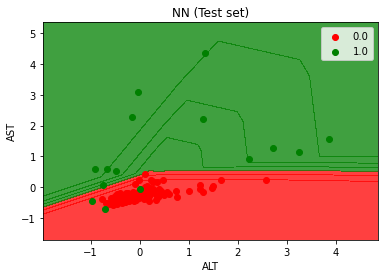

In [56]:
# Строим область значений. Они отделяются уже не линейно. Однако после усложения модели после увеличения входных нейронов с 2 до 8, качество модели улучшилось. 
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, cnn.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('NN (Test set)')
plt.xlabel('ALT')
plt.ylabel('AST')
plt.legend()
plt.show()

In [ ]:
# Выводы. Подводя итоги можно сказать, что исходная логистическая модель обладает повышенной качественностью и определяет 95% объектов верно. Так же стоит отметить, что позитивные и негативные значения отдлеяются линейно. Эту линейность мы используем для построения нейронной сети. При использовании стандартных параметров мы получаем качество модели худше, но при этом сохраняется линейность отделения позитивных от негативных. Для улучшения качества модели было принято решение увеличить количество нейронов на первом слое с 2 до 8, что позволило немного улучшить качество модели в целом, однако разделение положительных от отрицательных более не линейно. 